In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from skimage.morphology import skeletonize
from skimage import measure, morphology
from skimage.filters import threshold_otsu
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks


In [119]:
df1 = pd.read_csv('with.csv')
df2 = pd.read_csv('without.csv')

In [120]:
time_step = 400
target_y = 550

In [121]:
grouped = df1.groupby('TimeStep')
timestep_400_data = grouped.get_group(time_step)
phi_1 = timestep_400_data['Phi'].values
x_1 = timestep_400_data[':0'].values
y_1 = timestep_400_data[':1'].values

grouped2 = df2.groupby('TimeStep')
timestep_400_data2 = grouped2.get_group(time_step)
phi_2 = timestep_400_data2['Phi'].values
x_2 = timestep_400_data2[':0'].values
y_2 = timestep_400_data2[':1'].values

In [122]:

condition1 = (y_1 > 200) & (y_1 < 700)
condition2 = (y_2 > 200) & (y_2 < 700)


In [123]:
phi_1 = phi_1[condition1]
x_1 = x_1[condition1]
y_1 = y_1[condition1]
phi_binary = (phi_1 > 0).astype(int)

phi_2 = phi_2[condition2]
x_2 = x_2[condition2]
y_2 = y_2[condition2]
phi_binary2 = (phi_2 > 0).astype(int)

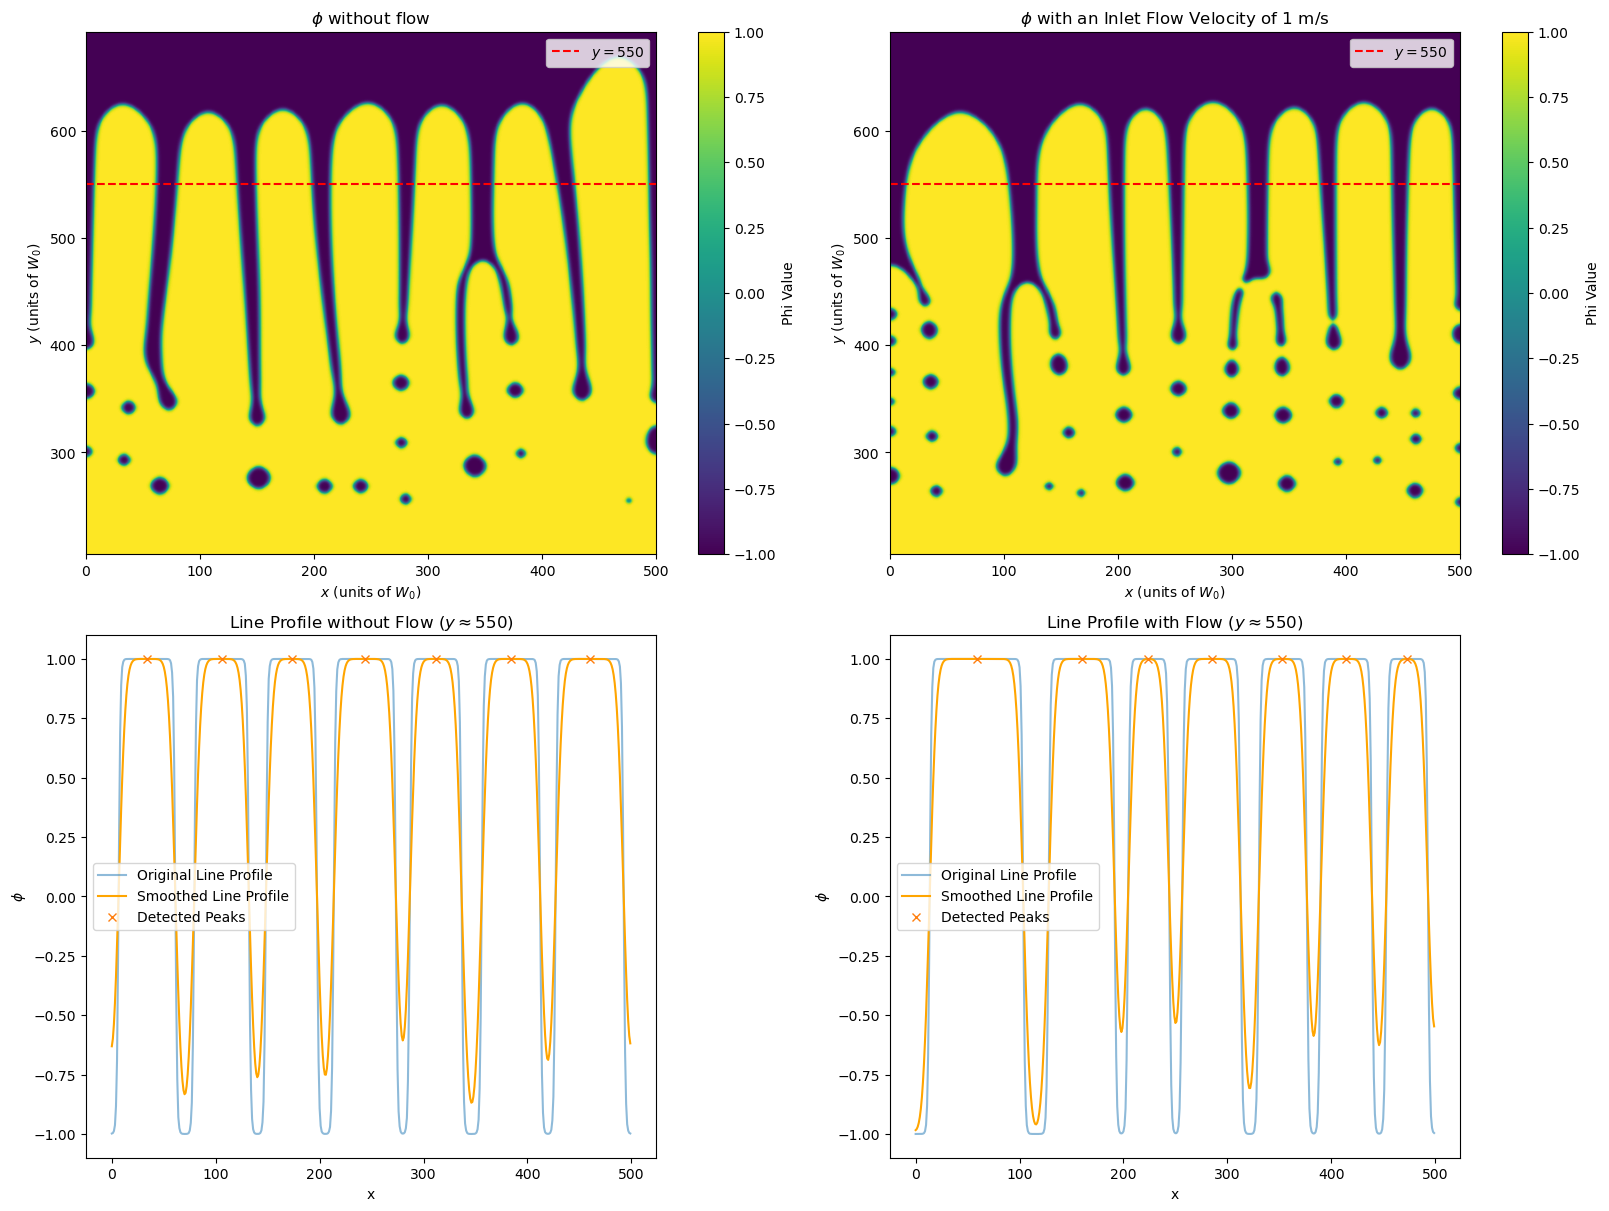

Average spacing without flow (physical units): 71.14
Average spacing with flow (physical units): 69.14
time_step = 400


In [124]:

# Interpolation for the first dataset
grid_x1, grid_y1 = np.linspace(x_1.min(), x_1.max(), 500), np.linspace(y_1.min(), y_1.max(), 500)
grid_x1, grid_y1 = np.meshgrid(grid_x1, grid_y1)
grid_phi1 = griddata((x_1, y_1), phi_1, (grid_x1, grid_y1), method='linear')

# Interpolation for the second dataset
grid_x2, grid_y2 = np.linspace(x_2.min(), x_2.max(), 500), np.linspace(y_2.min(), y_2.max(), 500)
grid_x2, grid_y2 = np.meshgrid(grid_x2, grid_y2)
grid_phi2 = griddata((x_2, y_2), phi_2, (grid_x2, grid_y2), method='linear')

# Create a 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# --- Top Left: Phi without flow ---
im1 = axs[0, 0].imshow(
    grid_phi1, 
    extent=(x_1.min(), x_1.max(), y_1.min(), y_1.max()),
    origin='lower', 
    aspect='auto', 
    cmap='viridis'
)
axs[0, 0].set_title(r'$\phi$ without flow')
axs[0, 0].set_xlabel(r"$x$ (units of $W_0$)")
axs[0, 0].set_ylabel(r"$y$ (units of $W_0$)")
axs[0, 0].axhline(y=target_y, color='red', linestyle='--', label=r"$y = 550$")
axs[0, 0].legend()

# --- Top Right: Phi with flow ---
im2 = axs[0, 1].imshow(
    grid_phi2, 
    extent=(x_2.min(), x_2.max(), y_2.min(), y_2.max()),
    origin='lower', 
    aspect='auto', 
    cmap='viridis'
)
axs[0, 1].set_title(r'$\phi$ with an Inlet Flow Velocity of 1 m/s')
axs[0, 1].set_xlabel(r"$x$ (units of $W_0$)")
axs[0, 1].set_ylabel(r"$y$ (units of $W_0$)")
axs[0, 1].axhline(y=target_y, color='red', linestyle='--', label=r"$y = 550$")
axs[0, 1].legend()

# --- Bottom Left: Line profile for Phi without flow ---
dx1 = grid_x1[0, 1] - grid_x1[0, 0]  # Grid spacing in x
row_index1 = np.argmin(np.abs(grid_y1[:, 0] - target_y))  # Closest row to y = 550
line_profile1 = grid_phi1[row_index1, :]
smoothed_profile1 = gaussian_filter(line_profile1, sigma=5)

# Find peaks in the smoothed line profile
expected_min_spacing = 20  # Adjust this based on your data
peaks1, _ = find_peaks(smoothed_profile1, height=0, distance=expected_min_spacing)

# Plot the smoothed line profile with peaks marked
axs[1, 0].plot(line_profile1, label='Original Line Profile', alpha=0.5)
axs[1, 0].plot(smoothed_profile1, label='Smoothed Line Profile', color='orange')
axs[1, 0].plot(peaks1, smoothed_profile1[peaks1], "x", label='Detected Peaks')
axs[1, 0].set_title(r"Line Profile without Flow ($y \approx 550$)")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel(r"$\phi$")
axs[1, 0].legend()

# --- Bottom Right: Line profile for Phi with flow ---
dx2 = grid_x2[0, 1] - grid_x2[0, 0]  # Grid spacing in x
row_index2 = np.argmin(np.abs(grid_y2[:, 0] - target_y))  # Closest row to y = 550
line_profile2 = grid_phi2[row_index2, :]
smoothed_profile2 = gaussian_filter(line_profile2, sigma=5)

# Find peaks in the smoothed line profile
peaks2, _ = find_peaks(smoothed_profile2, height=0, distance=expected_min_spacing)

# Plot the smoothed line profile with peaks marked
axs[1, 1].plot(line_profile2, label='Original Line Profile', alpha=0.5)
axs[1, 1].plot(smoothed_profile2, label='Smoothed Line Profile', color='orange')
axs[1, 1].plot(peaks2, smoothed_profile2[peaks2], "x", label='Detected Peaks')
axs[1, 1].set_title(r"Line Profile with Flow ($y \approx 550$)")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel(r"$\phi$")
axs[1, 1].legend()

# Add colorbars for the top plots
fig.colorbar(im1, ax=axs[0, 0], orientation='vertical', label='Phi Value')
fig.colorbar(im2, ax=axs[0, 1], orientation='vertical', label='Phi Value')

plt.show()

# --- Calculate and Print Spacing ---
# Without flow
peak_distances1 = np.diff(peaks1)
average_spacing1 = np.mean(peak_distances1)
spacing_physical1 = average_spacing1 * dx1
print(f"Average spacing without flow (physical units): {spacing_physical1:.2f}")

# With flow
peak_distances2 = np.diff(peaks2)
average_spacing2 = np.mean(peak_distances2)
spacing_physical2 = average_spacing2 * dx2
print(f"Average spacing with flow (physical units): {spacing_physical2:.2f}")
print( "time_step = " + str(time_step) )


Time-step: [200, 100, 150, 250, 300, 350, 400                   ]
without flow( PDAS ): [62.98, 45.49, 56.11, 63.13, 67.345, 71.81, 71.14      ]
with flow( PDAS ): [50.88,  41.99 , 46.29,   50.99, 59.98, 69.14,  69.14  ]


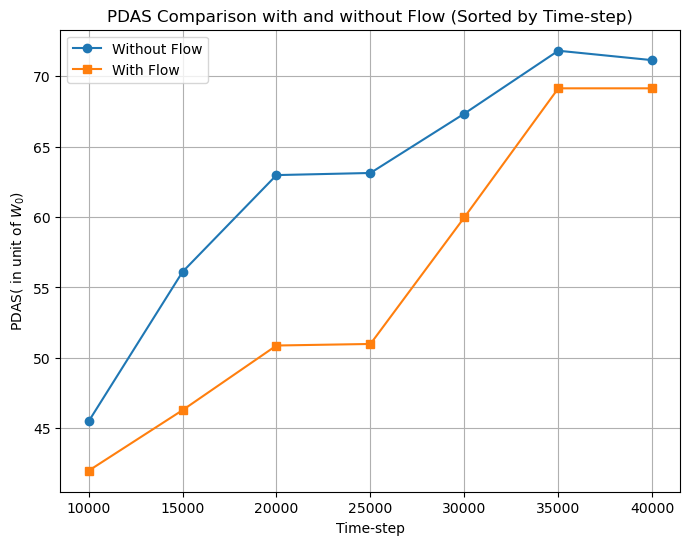

In [127]:
time_steps =  [200, 100, 150, 250, 300, 350, 400                   ] 
without_flow_pdas =  [62.98, 45.49, 56.11, 63.13, 67.345, 71.81, 71.14      ]
with_flow_pdas = [50.88,  41.99 , 46.29,   50.99, 59.98, 69.14,  69.14  ]

import pandas as pd

# Create a DataFrame to sort the data
data = {
    "Time-step": time_steps,
    "Without Flow": without_flow_pdas,
    "With Flow": with_flow_pdas,
}

df = pd.DataFrame(data)

# Sort the DataFrame by "Time-step"
df_sorted = df.sort_values(by="Time-step")

# Extract sorted data
sorted_time_steps = df_sorted["Time-step"].tolist() * 100
sorted_time_steps = [value * 100 for value in df_sorted["Time-step"].tolist()]
sorted_without_flow_pdas = df_sorted["Without Flow"].tolist()
sorted_with_flow_pdas = df_sorted["With Flow"].tolist()

# Plot the sorted data
plt.figure(figsize=(8, 6))
plt.plot(sorted_time_steps, sorted_without_flow_pdas, label="Without Flow", marker="o")
plt.plot(sorted_time_steps, sorted_with_flow_pdas, label="With Flow", marker="s")
plt.xlabel("Time-step")
plt.ylabel(f"PDAS( in unit of $W_0$)")
plt.title("PDAS Comparison with and without Flow (Sorted by Time-step)")
plt.legend()
plt.grid(True)
plt.show()